# Mental Health Classification - Predicting Depression With Mental Health Survey Statistics

By Matthew Ong and William Boulton

The goal of this project is to use supervised machine learning to predict a student's severity of depression. The dataset used in this project is provided via: https://figshare.com/articles/dataset/MHP_Anxiety_Stress_Depression_Dataset_of_University_Students/25771164?file=46172355

The data consists of survey responses from 2028 students across the top 15 universities in Bangladesh, and it includes sociodemographic information about students, as well as their academic department/major. The main markers for mental health conditions are given by the scores on GAD-7, PSS-10, and PHQ-9 diagnostic criteria for anxiety, stress, and depression respectively, adapted for college students.

## Objectives
1) Visualize the target (depression) distribution, across severity levels and overlap between other mental health conditions. This is done with TSNE/PCA dimensionality reduction.

2) Construct and compare a logistic regression and an XGBoost model for predicting a student's level of depression based on given survey answers.

3) Use Shapley explainability (XAI) scoring to learn which questions might correspond to high depression levels.

In [ ]:
from google.colab import files

# Request user to upload the given dataset
uploaded = files.upload()

# Upload file "MHP_Anxiety_Stress_Depression.csv"
for filename in uploaded.keys():
    print(f"Loaded file: {filename}")


Saving MHP_Anxiety_Stress_Depression.csv to MHP_Anxiety_Stress_Depression.csv
Loaded file: MHP_Anxiety_Stress_Depression.csv


In [ ]:
# All required imports
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Objective 1: Use TSNE to visualize stress, anxiety, and depression overlap.

Here, we will be observing the distribution of the 6 depression severity levels recorded across the 2028 responses. We will then use TSNE to meet the following two goals:
1) Derive a color-coded TSNE plot that shows the progression in feature patterns as depression severity worsens.
2) Show a color-channel visualization of how the 3 primary mental health conditions of stress, anxiety, and depression overlap.

In [ ]:
df = pd.read_csv(filename)

print(df.shape)
print(df.columns)
df.info()

# Check for missing values
df.isnull().sum()

(2028, 39)
Index(['Age', 'Gender', 'University', 'Department', 'Academic_Year',
       'Current_CGPA', 'waiver_or_scholarship', 'PSS1', 'PSS2', 'PSS3', 'PSS4',
       'PSS5', 'PSS6', 'PSS7', 'PSS8', 'PSS9', 'PSS10', 'Stress Value',
       'Stress Label', 'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7',
       'Anxiety Value', 'Anxiety Label', 'PHQ1', 'PHQ2', 'PHQ3', 'PHQ4',
       'PHQ5', 'PHQ6', 'PHQ7', 'PHQ8', 'PHQ9', 'Depression Value',
       'Depression Label'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    2028 non-null   object
 1   Gender                 2028 non-null   object
 2   University             2028 non-null   object
 3   Department             2028 non-null   object
 4   Academic_Year          2028 non-null   object
 5   Current_CGPA           2028 no

,0
Age,0
Gender,0
University,0
Department,0
Academic_Year,0
Current_CGPA,0
waiver_or_scholarship,0
PSS1,0
PSS2,0
PSS3,0


/tmp/ipython-input-177815343.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Depression Label Short', data=df, palette='coolwarm', edgecolor='black')


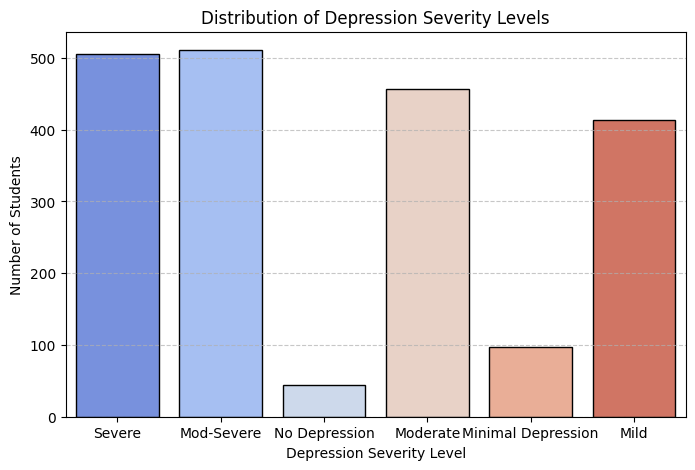

In [ ]:
# Show distribution of target depression levels
plt.figure(figsize=(8,5))
df['Depression Label Short'] = df['Depression Label'].replace({
    'Non-depressed': 'None',
    'Mild Depression': 'Mild',
    'Moderate Depression': 'Moderate',
    'Moderately Severe Depression': 'Mod-Severe',
    'Severe Depression': 'Severe'
})
sns.countplot(x='Depression Label Short', data=df, palette='coolwarm', edgecolor='black')
plt.title('Distribution of Depression Severity Levels')
plt.xlabel('Depression Severity Level')
plt.ylabel('Number of Students')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Depression Severity Levels:

*   0 = "No Depression"
*   1 = "Minimal Depression"
*   2 = "Mild Depression"
*   3 = "Moderate Depression"
*   4 = "Moderately Severe Depression"
*   5 = "Severe Depression"

Note: This distribution will be seen later when visualizing performance metrics. It seems there is an imbalance in the dataset, where not a lot of students' responses evaluate to a depression severity level of "minimal depression" or "moderately severe depression." Perhaps this suggests those categories are too ambiguous.  

In [ ]:
# Choose one main categorical column as target
target = 'Depression Label'

# Encode string labels to integers
le = LabelEncoder()
df[target] = le.fit_transform(df[target])


In [ ]:
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target])
y = df[target]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


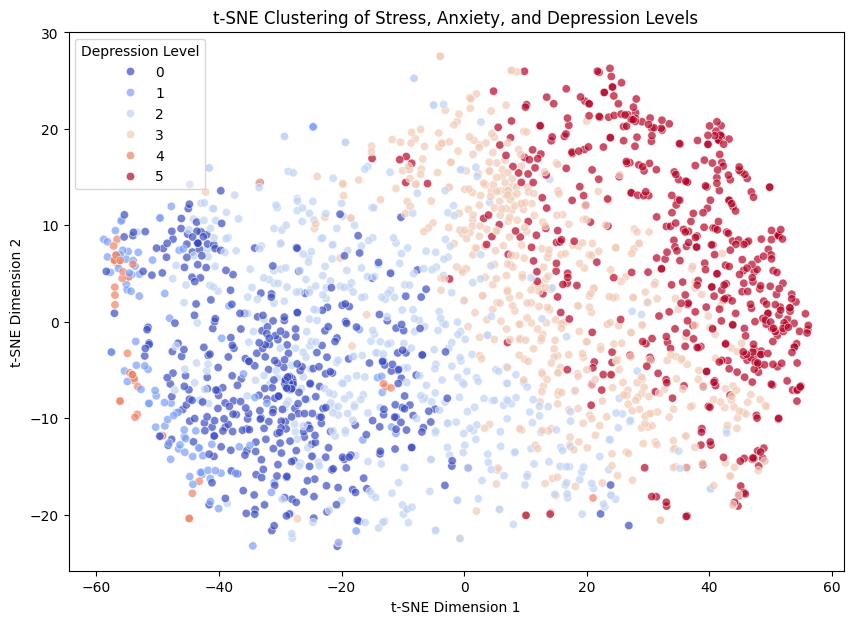

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    hue=y,
    palette='coolwarm',
    alpha=0.7
)
plt.title('t-SNE Clustering of Stress, Anxiety, and Depression Levels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Depression Level')
plt.show()


## TSNE Visualization of Target
TSNE takes high-dimensional data and produces a 2D map of that data so we can visualize patterns. In contrast to PCA, TSNE looks at similarity between data points.

In the above plot, we can see a clear **gradient progression** as depression levels increase, which tells us that the features used (GAD-7, PSS-10, and PHQ-9, alongside age or department) effectively separate groups of students with differing depression severity.

To describe the underlying intuitions, we can give an example using the sociodemographic features:
- Age (18–22, 23–26, etc.)
- Gender (Male/Female)
- Department (Engineering, Business, etc.)
- Academic Year (First Year, Second Year…)
- Current CGPA ranges (2.50–2.99, 3.00–3.39, etc.)
- Waiver / Financial Support (Yes/No)

We use StandardScaler to encode the categorical columns into numerical inputs. This ensures that GPA and age group remain comparable despite being on different numerical scales.

Instead of using PCA, we use TSNE. This is because we are not worried about the global variance; we just want to know how the conditions overlap, ie. how similar the students are in terms of mental health.

For each pair of students:

$$p_{ij} \propto \exp(-\frac{||x^{[i]}-x^{[j]}||^2}{2\sigma^2_{i}})$$

If the pair's similarity probability as measured above `p_{ij}` is high, the students likely have many similar features, such as GPA, academic department, age range, and therefore similar mental health conditions.

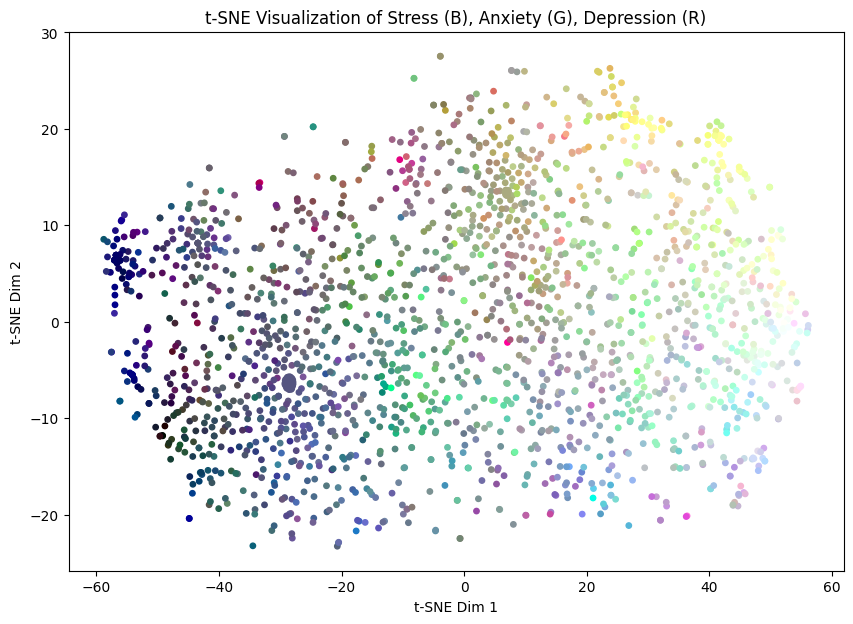

In [ ]:
def normalize(col):
    return (df[col] - df[col].min()) / (df[col].max() - df[col].min())

colors = np.stack([
    normalize('Depression Value'),  # Red => Depression
    normalize('Anxiety Value'),     # Green => Anxiety
    normalize('Stress Value')       # Blue => Stress
], axis=1)

plt.figure(figsize=(10,7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, s=15)
plt.title('t-SNE Visualization of Stress (B), Anxiety (G), Depression (R)')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()

## TSNE RGB Color Channel Visualization of Depression, Stress, and Anxiety Overlap

As opposed to mapping out only the target variable, we want to see the comorbidity of the three major mental health conditions shown in the dataset. Why do we only target depression in this project? This is because it is, at least subjectively, the most severe and impactful of the conditions on a student's academic career. Stress and anxiety can both be considered transient but do show up and contribute heavily to a diagnosis of depression.

What we did previously with TSNE has *not* changed. We are still spacing out the data points and representing them with respect to their similarities.

### Color Channels
We encode the three continuous columns of stress, anxiety, and depression simultaneously using the mapping:
*   Red channel → Depression Value
*   Green channel → Anxiety Value
*   Blue channel → Stress Value

The `normalize` function maps each variable to a range of [0, 1].

$$normalize(x_{i}) = \frac{x_{i} - min(x)}{max(x) - min(x)}$$
Where the RGB signature for each individual student is a stacked triplet of:
$$color_{i} = [r_{i}, g_{i}, b_{i}] = [depression_{i}, anxiety_{i}, stress_{i}]$$

### How to Interpret the Plot Visually
- A reddish point → high Depression
- A greenish point → high Anxiety
- A bluish point → high Stress
- A white / light-colored point → high on all three
- A dark / grayish point → low on all three

The comparisons between the two graphs make sense. Look at the upper right clusters of yellow and orange colored data points. These are students with high anxiety (green coloring) and high depression (red coloring). This is an expected correlation. These patterns also verify that this dataset is in a good structure with which to proceed with building predictive models.

# Objective 2: Compare two multi-class classification models Logistic Regression and XGBoost (Decision Trees).

Among the many candidate algorithms that we can use, we have narrowed down logistic regression and XGBoost as the priority choices.

A random forest ensemble would work well, but it lacks interpretability.

Naïve Bayes (MultinomialNB or GaussianNB) would fit for high performance as a baseline model, but because it makes the assumption of feature independence, we obviously cannot use it, as we observed in the above visualization plots that the features are very correlated.

If we seek higher accuracy in the future, we also will implement ridge/lasso regularization to the logistic regression model. We may also stack the logistic regression model with XGBoost in an ensemble.

We will be dropping several columns from the dataset in training these two models.

*   University: We want to be able to predict students' depression outside of Bangladesh universities
*   Stress/Anxiety Labels: Redundant with Stress and Anxiety values
*   Depression Value: Directly encodes Depression Label, which is our target
*   PHQ's 1, 2, 6, and 9: These are the most impactful "giveaway" questions that pertain to feeling depressed or suicidal ideation. This is diagnostic criteria that leaks information about the target class. Specifically they are: PHQ1 (anhedonia), PHQ2 (directly asked if the student is feeling depressed), PHQ6 (directly asked if the student feels bad about themselves), and PHQ9(suicidal ideation).

## Multinomial Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df = pd.read_csv(filename)

# Drop the redundant columns for stress/anxiety labels and the university label
# Drop Depression Value as that would be directly encoded to the target class
# Drop PHQ's 1, 2, 6, and 9 as they clearly leak information about the target
df = df.drop(columns=["University", "Stress Label", "Anxiety Label",
                      "Depression Value", "PHQ1", "PHQ2", "PHQ6", "PHQ9"])
df.head()


,Age,Gender,Department,Academic_Year,Current_CGPA,waiver_or_scholarship,PSS1,PSS2,PSS3,PSS4,...,GAD5,GAD6,GAD7,Anxiety Value,PHQ3,PHQ4,PHQ5,PHQ7,PHQ8,Depression Label
0,18-22,Female,Engineering - CS / CSE / CSC / Similar to CS,Second Year or Equivalent,2.50 - 2.99,No,3,4,3,2,...,2,2,2,15,3,2,2,2,3,Severe Depression
1,18-22,Male,Engineering - CS / CSE / CSC / Similar to CS,Third Year or Equivalent,3.00 - 3.39,No,3,3,4,2,...,1,3,2,12,2,2,2,2,2,Moderately Severe Depression
2,18-22,Male,Engineering - CS / CSE / CSC / Similar to CS,Third Year or Equivalent,3.00 - 3.39,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,No Depression
3,18-22,Male,Engineering - CS / CSE / CSC / Similar to CS,Third Year or Equivalent,3.00 - 3.39,No,3,1,2,1,...,2,1,2,10,2,1,2,2,2,Moderate Depression
4,18-22,Male,Engineering - CS / CSE / CSC / Similar to CS,Second Year or Equivalent,2.50 - 2.99,No,4,4,4,2,...,1,1,3,14,3,3,1,0,3,Severe Depression


In [ ]:
X = df.drop(columns=["Depression Label"])
y = df["Depression Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Build a pipeline that scales numerical values and one-hot-encodes
# categorial columns in a preprocessing step. Then build a
# multinomial logistic regression with the saga solver.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Separate features (X) and target (y)
X = df.drop(columns=["Depression Label"])
y = df["Depression Label"]

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data: scaling
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Build the logistic regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(
        random_state=42,
        solver='saga',
        multi_class='multinomial',
        max_iter=3000
    ))
])

param_grid_lr = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l2']
}

grid_search_lr = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid_lr,
    cv=3,
    scoring='accuracy',
    verbose=20,
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)

print("Best Parameters:", grid_search_lr.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_lr.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Best Cross-Validation Accuracy: 0.7152924594785061


In [ ]:
# Predict with the best model
best_model = grid_search_lr.best_estimator_

predictions = best_model.predict(X_test)

Accuracy.........: 72.9064
Precision........: 72.7160
Recall...........: 72.9064
F1 score.........:0.7274
Confusion matrix using Seaborn heatmap:


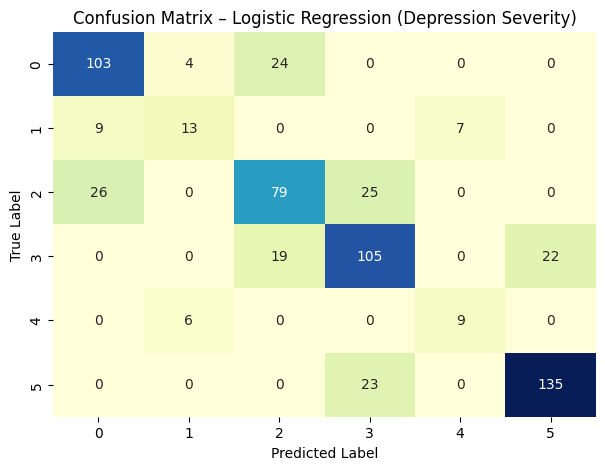

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,auc, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Report the predctive performance metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

# Evaluate predictions
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"F1 score.........:{(f1):.4f}")

cm = confusion_matrix(y_test, predictions)

print(f"Confusion matrix using Seaborn heatmap:")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap="YlGnBu");
plt.title("Confusion Matrix – Logistic Regression (Depression Severity)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Multi-class XGBoost

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.4 MB/s eta 0:00:00


In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split after encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Build a pipeline scales and one-hot-encodes using the
# reused preprocessor from the LR model. Then build a
# multi-class XGBoost with softmax

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import VerboseCallback
from tqdm.auto import tqdm
import sys

# Build the XGB pipeline
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(
        objective="multi:softmax",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=0
    ))
])

search_spaces_xgb = {
    'xgb__learning_rate': Real(0.001, 0.2),
    'xgb__max_depth': Integer(2, 10),
    'xgb__n_estimators': Integer(200, 400),
    'xgb__subsample': Real(0.5, 1.0),
    'xgb__colsample_bytree': Real(0.5, 1.0),
    'xgb__min_child_weight': Integer(1, 10),
    'xgb__reg_lambda': Real(0, 2),
    'xgb__reg_alpha': Real(0, 2),
    'xgb__gamma': Real(0, 5)
}

# tqdm progress bar to avoid spam output
pbar = tqdm(total=50)

def on_step(optim_result):
    pbar.update(1)

bayes_search_xgb = BayesSearchCV(
    estimator=xgb_pipeline,
    search_spaces=search_spaces_xgb,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=0
)

bayes_search_xgb.fit(X_train, y_train, callback=[on_step])

print("Best XGB Parameters:", bayes_search_xgb.best_params_)
print("Best XGB Cross-Validation Accuracy:", bayes_search_xgb.best_score_)
pbar.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Best XGB Parameters: OrderedDict({'xgb__colsample_bytree': 0.842065534940815, 'xgb__gamma': 0.0, 'xgb__learning_rate': 0.10361652094227414, 'xgb__max_depth': 2, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 314, 'xgb__reg_alpha': 0.0, 'xgb__reg_lambda': 1.7247429788428261, 'xgb__subsample': 0.9394792999463192})
Best XGB Cross-Validation Accuracy: 0.718816067653277


In [ ]:
# Predict with the best model
best_model = bayes_search_xgb.best_estimator_

predictions = best_model.predict(X_test)

Accuracy.........: 73.0706
Precision........: 73.1044
Recall...........: 73.0706
F1 score.........:0.7307
Confusion matrix using Seaborn heatmap:


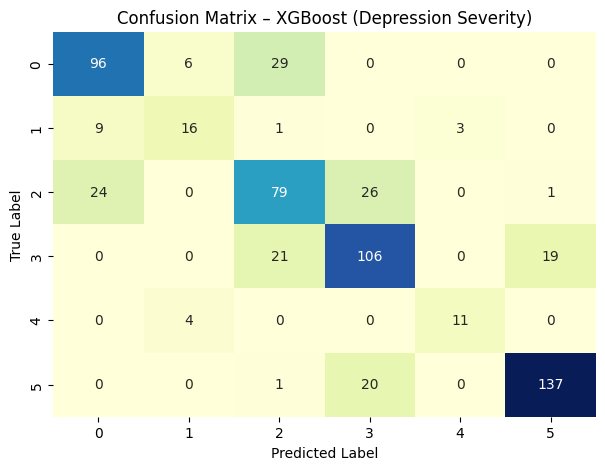

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,auc, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Report the predctive performance metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

# Evaluate predictions
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"F1 score.........:{(f1):.4f}")

cm = confusion_matrix(y_test, predictions)

print(f"Confusion matrix using Seaborn heatmap:")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap="YlGnBu");
plt.title("Confusion Matrix – XGBoost (Depression Severity)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Objective 3: Use SHAP Explainability Scoring to determine which specific features have the highest impact on depression predictions.

Our goal with this next objective is to derive feature importance by using SHapley Additive exPlanations (SHAP), which is a model-agnostic explainability tool that uses foundational principles from game theory to assign a score to each feature that corresponds to that feature's amount of contribution or impact on the prediction.

In [ ]:
import shap

# Extract previously fitted preprocessor and XGBoost model
pre = best_model.named_steps["preprocessor"]
xgb = best_model.named_steps["xgb"]

In [ ]:
# Transform training data into the exact numeric matrix used by XGBoost
X_train_transformed = pre.transform(X_train)

# Grab the full feature names (numerical + one-hot categorical)
feature_names = (
    pre.named_transformers_['num'].named_steps['scaler']
      .get_feature_names_out(numerical_features).tolist()
    +
    pre.named_transformers_['cat'].named_steps['onehot']
      .get_feature_names_out(categorical_features).tolist()
)

# Build SHAP explainer using TreeExplainer (XGB uses DT's)
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values
shap_values = explainer.shap_values(X_train_transformed)

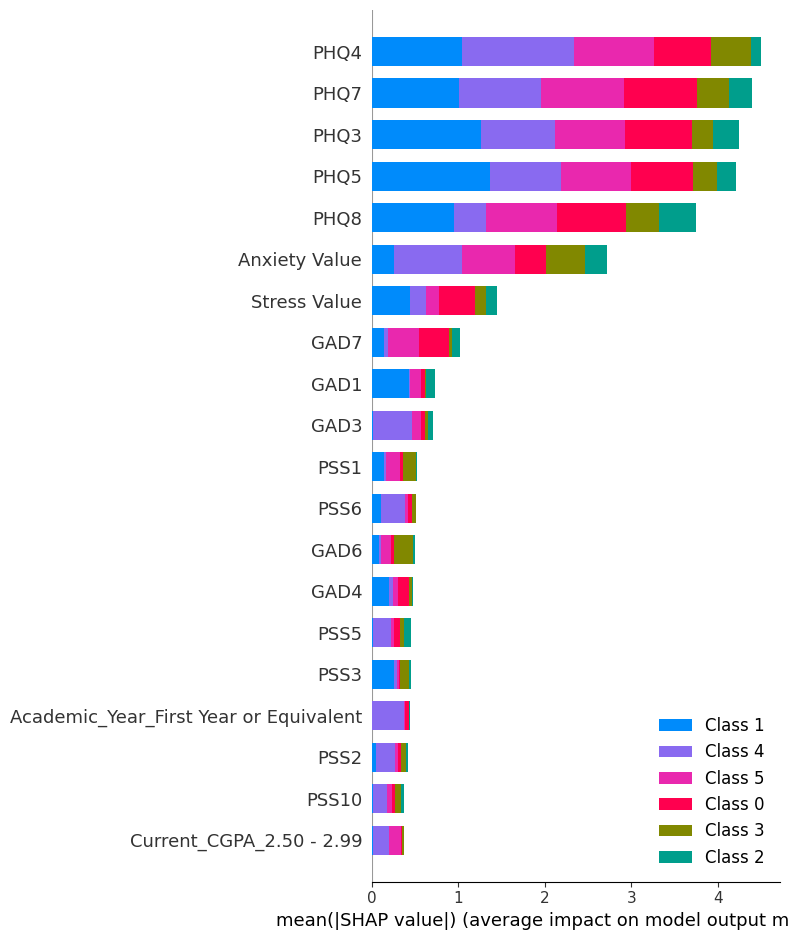

In [ ]:
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")


### Multi-class SHAP Bar Plot Output
The bar plot above displays the approximate feature importance values for the following class distribution:
* Class 0 → No Depression
* Class 1 → Minimal Depression
* Class 2 → Mild Depression
* Class 3 → Moderate Depression
* Class 4 → Moderately Severe Depression
* Class 5 → Severe Depression
Each bar's length denotes the mean absolute SHAP value for that feature for the given class.

### How SHAP Works
Given a model `f(x)`, a prediction to the sample `x`, a feature/predictor `i`, and a subset of other features `S`:
SHAP tells us the difference that `i` makes to the prediction, averaged across all possible predictors.

SHAP takes all possible subsets `S` of features excluding `i`, computes the model's prediction with and without `i` included, and computes the difference between the two predictions. Then, it weighs each contribution by the probability that subset S appears in a random permutation, and sums all of them up.

The following code will use SHAP to give output feature importance values according to one specific class, or our target class "Depression Label."


shap_values_severe shape: (1419, 57)
X_train_transformed shape: (1419, 57)
Number of feature names: 57


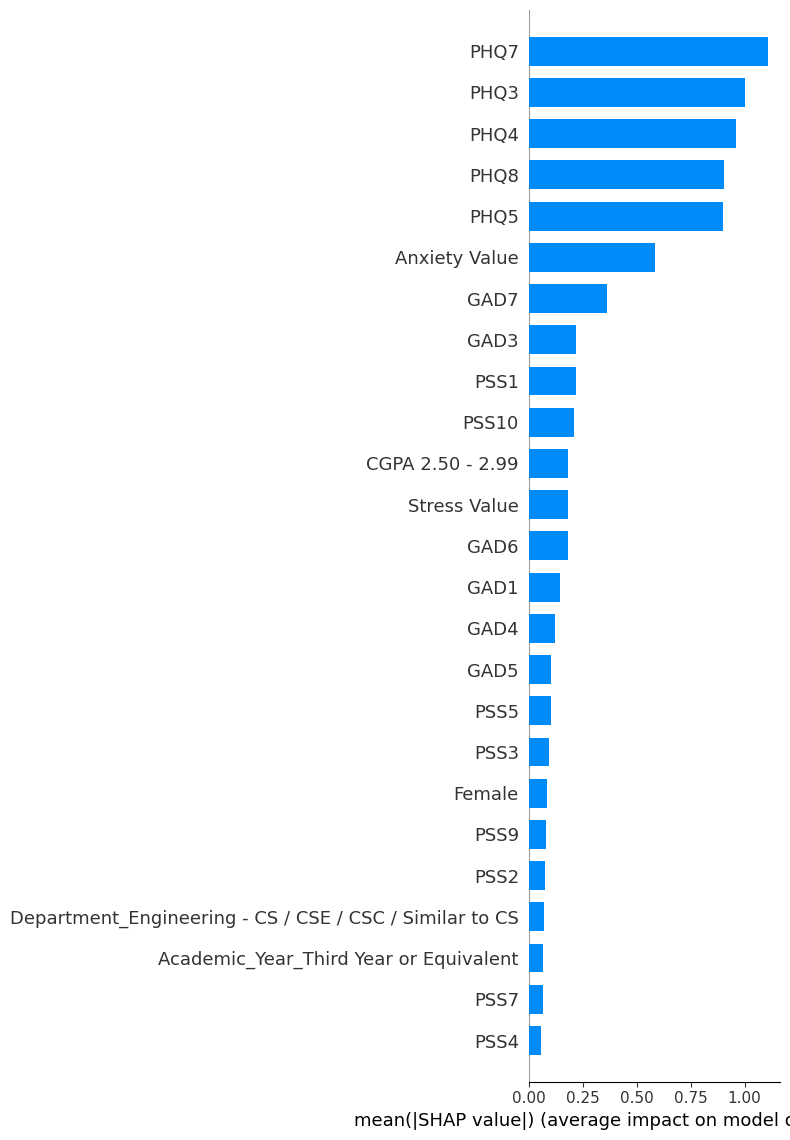

In [ ]:
# Identify class index for "Severe Depression"
severe_idx = list(le.classes_).index("Severe Depression")

# Extract SHAP values for Severe Depression
shap_values_severe = shap_values[:, :, severe_idx]

print("shap_values_severe shape:", shap_values_severe.shape)
print("X_train_transformed shape:", X_train_transformed.shape)
print("Number of feature names:", len(feature_names))

clean_feature_names = [name.replace("Current_CGPA_", "CGPA ").replace("Gender_", "")
                       for name in feature_names]

shap.summary_plot(
    shap_values_severe,
    X_train_transformed,
    feature_names=clean_feature_names,
    plot_type="bar",
    max_display=25 # feature listing count, raise to see more
)

The above plot shows the same feature importance bars as the previous bar graph, but this time it shows only the amount that each feature affects predictions of "Severe Depression." This is lacking in information, simply because the PSS, GAD, and PHQ questions are encoded numerically.

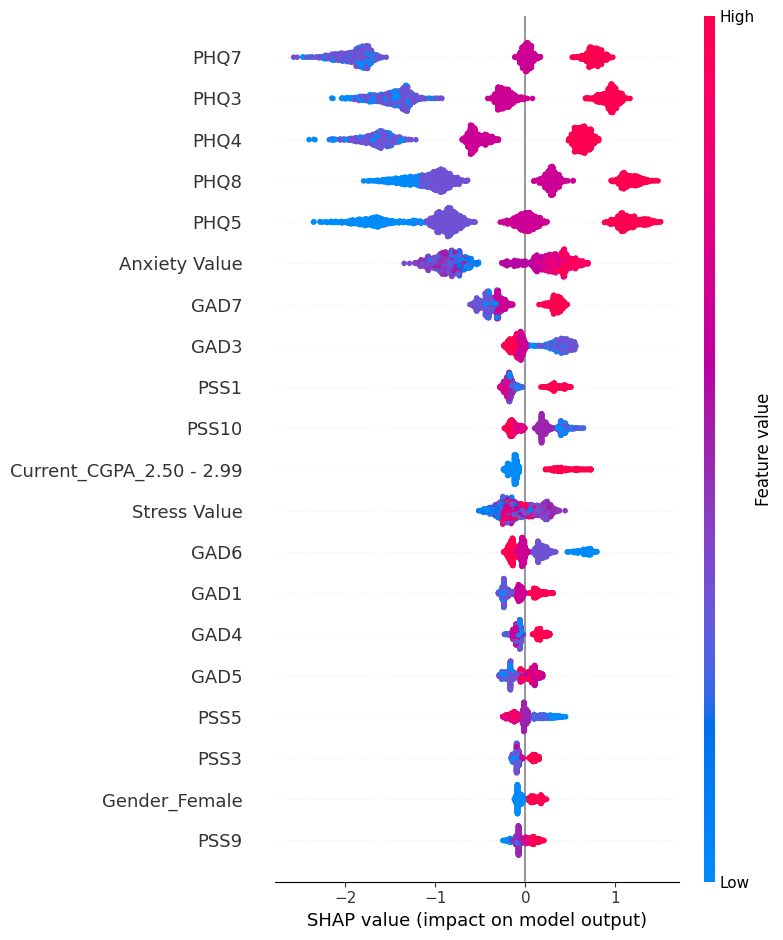

In [ ]:
shap.summary_plot(
    shap_values_severe,
    X_train_transformed,
    feature_names=feature_names
)

### Feature Importance Beeswarm Plot
This plot indicates what feature values push the prediction towards a "Severe Depression" label and by how much. The color corresponds to the feature value, where in these cases, red denotes a high value or worse symptoms, and blue denotes a low value or weak symptoms. This is organized from most important features to least important features.

From this plot, we obtain the following actionable insights into predicting and preventing academic depression:

* PHQ7 - The question corresponds to a lack of concentration on activities like reading or watching television.
* PHQ3 - This question asks about sleep quality.
* PHQ4 - Talks about having little energy or feeling tired during the day.
* PHQ8 - Asks about speaking too slowly or if people have been noticing sluggish behavior.
* PHQ5 - Asks about poor appetite or overeating.

The PHQ questions are obviously the most important because they comprise the section of the survey that directly correlates to high depression. Still, we learn some valuable information from them. The features that we are most interested in follow right after the PHQ questions. The SHAP values for these questions explain the intersection between the main classes as observed in the TSNE data visualization plots from Objective 1.

10 of these more interesting predictors are as follows:

* Anxiety Value - The total severity of anxiety for the observation measured numerically.
* GAD7 - How often the responder has felt afraid or dreadful that something awful might occur.
* GAD3 - Trouble relaxing due to academic pressure?
* PSS1 - Feeling upset due to academic affairs
* PSS10 - Question pertains to how difficult or cumbersome academic affairs are becoming for the responder.
* The category for CGPA: 2.50-2.99 - indicates the responder has a low GPA.
* Stress Value - the total severity of stress for the observation measured numerically.
* GAD6 - Restless or difficulty sitting still due to academic pressures.
* GAD1 - Nervous, anxious, or on the edge due to academic pressures.
* GAD4 - How easily annoyed or irritated as a result of academic pressures.


Severe Depression class index: 5


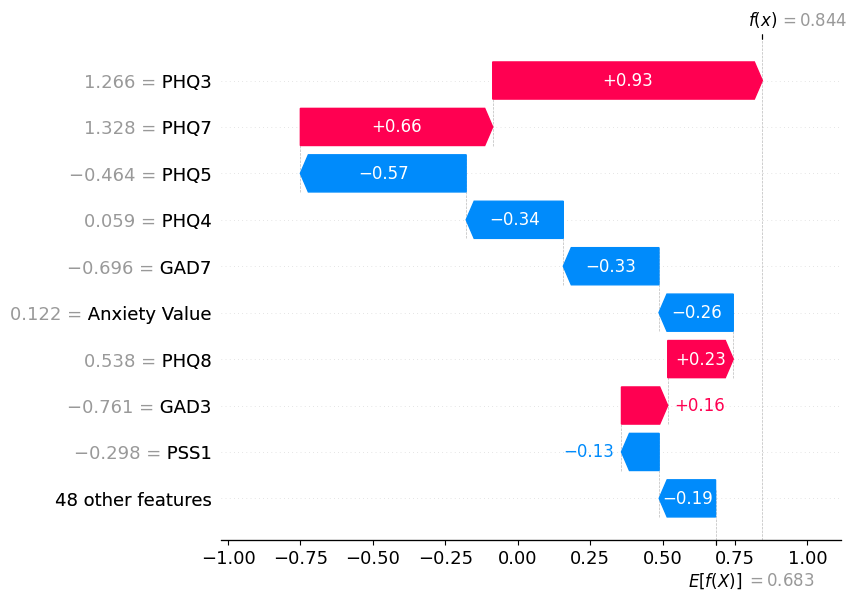

In [ ]:
severe_idx = list(le.classes_).index("Severe Depression")
print("Severe Depression class index:", severe_idx)

i = 500  # choose any index

shap_values_severe_i = shap_values[i, :, severe_idx]
expected_value_severe = explainer.expected_value[severe_idx]

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_severe_i,
        base_values=expected_value_severe,
        data=X_train_transformed[i],
        feature_names=feature_names
    )
)


### Individual Observation Waterfall Plot
The above waterfall plot shows how the model arrived at a prediction of "Severe Depression" for the case `i = 500`, or the 500th entry in the dataset. We can set this number to be any observation. This simply further representation of what SHAP is actually measuring.

Each bar shows how much a feature increases (red) or decreases (blue) the probability that this student belongs to the Severe Depression class.

For the most salient examples:

* PHQ3 = +0.93
→ A high PHQ3 score strongly pushes the prediction toward Severe Depression.
* PHQ7 = +0.66
→ Concentration problems also increase severity likelihood significantly.
* PHQ5 = –0.57
→ A low appetite disturbance score pulls the prediction away from Severe Depression.
* PHQ4 = -0.34
→ Better energy levels during the day support a lesser severe depression likelihood
* GAD7 = –0.33
→ Low anxiety reduces the severe-depression likelihood.

The following actionable insights that universities can apply to prevent academic mental illness can therefore be organized in a set of tiers:

* Tier 1 - Highest Priority: These are all of the PHQ questions that directly correlate to depression. This includes poor sleep, concentration problems, fatigue, appetite changes, or psychomotor issues.
* Tier 2 - High Priority: These are the comorbid features (anxiety and stress). Universities should offer CBT or anxiety/fear management programs and workshops to reduce stigma surrounding mental illness and help students feel more confident in their academic performance.
* Tier 3 - Moderate Priority: These are primarily the perceived stress scores that have mild comorbidity with depression. Universities could apply de-stress events after exam periods, counseling programs, and transition programs.

We strongly encourage future extension of this project to work beyond this limited feature dataset, eventually using text embeddings training neural networks.